# Generate Ground Truth Contact Maps

Contact maps is a binary matrix that represent the tertiary structure of a protein in 2D. Each element in the matrix is a binary value, 1 if two given amino acids are in spatially close as defined by a threshold value, 0 if they are not. The distance is between the alpha-carbon atoms (Cα) of the two amino acids, and is measured in angstroms (Å). The standard threshold value used for contact maps is usually 6-12Å. 

Contact maps can be generated in multiple ways: from structural data derived from imperical measurements; from attention maps of a protein language model's attention heads as was done in the ESM models; from the categorical jacobian of a protein language model's logit outputs as was done in the extension for the ESM-2.

To be able to compare how accurate these interpretation methods are for generating contact maps, they need to be compared to ground truth contact maps generated from imperical measurements. As no data set currently exsits of proteins and their contact map, I need to write code to carry out this transformation in order to acquire this data. 

Experiment 1:
Aim - to determine what the source of the discontinued pattern in the contact maps is. 
Hypothesis - The protein sequence is split into multiple chains causing the discontinious tile patterns to form
Test - for each chain, create its own contact map thus seperating the protein into those segments, if the tile pattern persists then it must mean the source is not the chains. 

In [1]:
import Bio.PDB
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run utils.ipynb

In [2]:
# Get location of each alpha-carbon atom at each amino acid residue
def get_ca_atoms(protein):
    residues = protein.get_residues()
    ca_atoms = np.array([residue['CA'].coord for residue in residues if 'CA' in residue])
    return ca_atoms

# Get the distance between the alpha-carbon atoms of each possible pair of amino acid
def get_distances(ca_atoms):
    # calculate euclidean distance between every possible Cα pairing 
    distances = np.linalg.norm(ca_atoms[:, np.newaxis, :] - ca_atoms[np.newaxis, :, :], axis=-1)
    return distances

# UNUSED - Apply the threshold distance value to generate a binary contact map 
def get_contact_map(distances,cutoff_distance=8):
        contact_map = distances < cutoff_distance
        return contact_map

# Generate one contact map for each protein (by model or by residue)
def get_contact_maps_per_protein(proteins):
    contact_maps = {}
    for protein,model in proteins.items():
        distances =  get_distances(get_ca_atoms(model))
        contact_maps[protein] = distances
    return contact_maps

# Generate one contact map for each protein's chain 
def get_contact_maps_per_chain(proteins):
    contact_maps = {}
    for protein,chains in proteins.items():
        for chain in chains:
            protein_chain = f"{protein}_{chain.id}"
            distances =  get_distances(get_ca_atoms(chain))
            contact_maps[protein_chain] = distances
    return contact_maps

In [3]:
# Alternative Method from Lupo et al. (2022) 
# code source : https://github.com/Bitbol-Lab/Phylogeny-MSA-Transformer/blob/v1.0/utils.py
def calc_CA_dist_matrix(chain, idx_subset):
    """Returns a matrix of C-alpha distances in a (subset of a) chain"""
    idx_subset = set(idx_subset)
    residue_coords = [residue["CA"].coord for i, residue in enumerate(chain.get_residues()) if i in idx_subset]
    return squareform(pdist(residue_coords))


In [33]:
def display_contact_map(protein_name, contact_map):
    plt.matshow(contact_map)
    plt.title(protein_name, fontsize=20)
    plt.show()

# def display_all_contact_maps(contact_maps):
#     for  protein_name,contact_map in contact_maps.items():
#         plt.matshow(contact_maps[protein_name])
#         plt.title(protein_name, fontsize=20)
#         plt.show()

def calc_percentage_diff(val1,val2):
    return round(100-(val1/val2)*100,1)

# Check if the number of residues form the pdb structure file matches with the length of the sequence from the FASTA file
def compare_residue_len_to_seq_len(protein_name, ca_atoms_len, seq_len):
    if ca_atoms_len==seq_len:
        print(f"Size of contact map for protein {protein_name} aligns with the length of protein sequence")
        print(f"Size of contact map:{ca_atoms_len}, Length of sequence:{seq_len}")
    elif   ca_atoms_len<seq_len:
        print(f"Size of contact map for protein {protein_name} is shorter than the length of the original protein sequence. Some residues are missing in this contact map.")
        print(f"Size of contact map:{ca_atoms_len} VS Length of sequence:{seq_len}")
        diff = calc_percentage_diff(ca_atoms_len, seq_len)
        print(f"{diff}% of the sequence is missing.")
    else:
        print(f"Size of contact map for protein {protein_name} is longer than the length of the original protein sequence. There are extra residues present in the structure.")
        print(f"Size of contact map:{ca_atoms_len} VS Length of sequence:{seq_len}")
        diff = calc_percentage_diff(seq_len,ca_atoms_len)
        print(f"{diff}% of the carbon atoms are excess.")

def analyse_and_display_all_contact_maps(contact_maps,sequence_lengths,ca_atoms_lengths):
    print(sequence_lengths)
    print(ca_atoms_lengths)
    for  protein_name,contact_map in contact_maps.items():
        display_contact_map(protein_name,contact_map)
        try: 
            ca_atoms_len = ca_atoms_lengths[protein_name]
            # extract exact protein name if contact map is generated from a chain
            if len(protein_name)>4:
                protein_name = protein_name[:4]
            seq_len = sequence_lengths[protein_name]
            compare_residue_len_to_seq_len(protein_name, ca_atoms_len, seq_len)
        except KeyError:
            print(f"Protein {protein_name} is not present in the folder")
        
def set_up(contact_maps,folder_path = "protein_sequences"):
    data,sequence_lengths = process_fasta_files(folder_path)
    sequence_lengths = {id[:4]:length for (id,_),length in zip(data,sequence_lengths)}
    ca_atoms_lengths = {protein:len(distances) for protein,distances in contact_maps.items()}
    return sequence_lengths,ca_atoms_lengths

C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6715.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6716.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6717.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6718.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6719.
  warnings.warn(
C:\Users\aguba\AppData\Lo

{'1MAZ': 221, '1UNQ': 125, '2M7D': 20, '2OCJ': 219, '4ELJ': 656, '4OBE': 170, '8PI0': 168}
{'1MAZ': 143, '1UNQ': 117, '2M7D': 20, '2OCJ': 776, '4ELJ': 590, '4OBE': 339, '8PI0': 168}


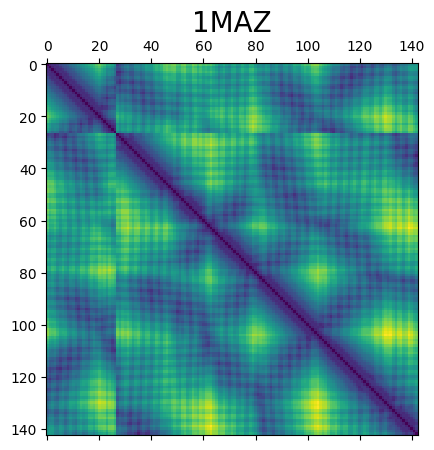

Size of contact map for protein 1MAZ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:143 VS Length of sequence:221
35.3% of the sequence is missing.


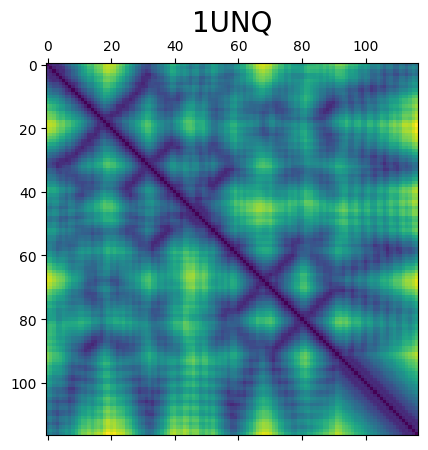

Size of contact map for protein 1UNQ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:117 VS Length of sequence:125
6.4% of the sequence is missing.


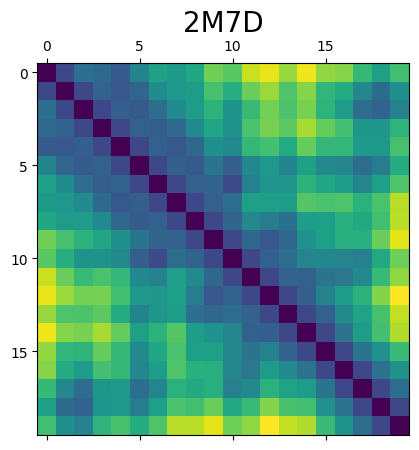

Size of contact map for protein 2M7D aligns with the length of protein sequence
Size of contact map:20, Length of sequence:20


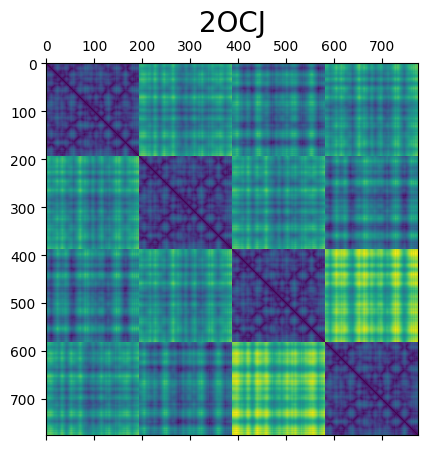

Size of contact map for protein 2OCJ is longer than the length of the original protein sequence. There are extra residues present in the structure.
Size of contact map:776 VS Length of sequence:219
71.8% of the carbon atoms are excess.


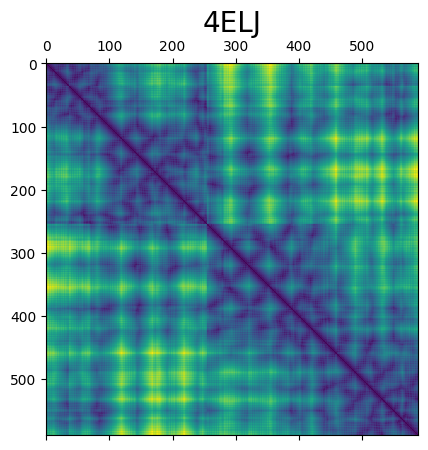

Size of contact map for protein 4ELJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:590 VS Length of sequence:656
10.1% of the sequence is missing.


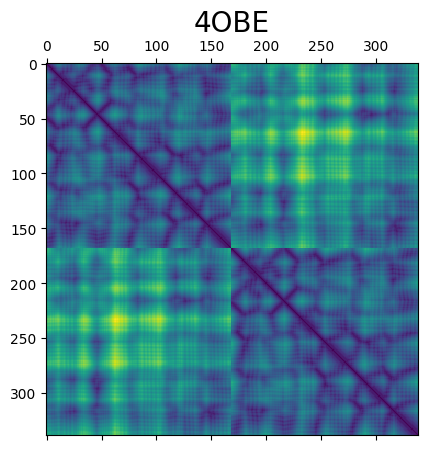

Size of contact map for protein 4OBE is longer than the length of the original protein sequence. There are extra residues present in the structure.
Size of contact map:339 VS Length of sequence:170
49.9% of the carbon atoms are excess.


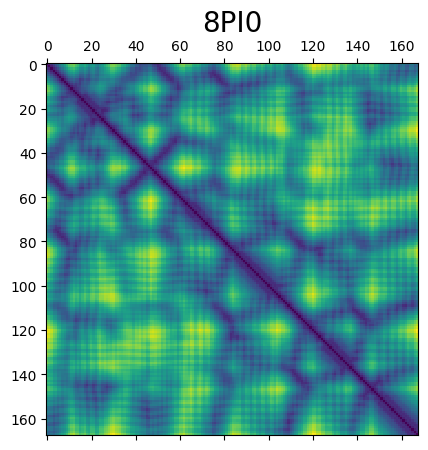

Size of contact map for protein 8PI0 aligns with the length of protein sequence
Size of contact map:168, Length of sequence:168


In [34]:
#Option 1: parse using model
# parse protein structure data
models = process_pdb_files("protein_structures")
# generate contact maps from structure data
contact_maps = get_contact_maps_per_protein(models)
# visualise and analyse
sequence_lengths,ca_atoms_lengths = set_up(contact_maps)
analyse_and_display_all_contact_maps(contact_maps,sequence_lengths,ca_atoms_lengths)
# print(f"SEQ: {sequence_lengths}")
# print(f"CAA: {ca_atoms_lengths}")

C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6715.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6716.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6717.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6718.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6719.
  warnings.warn(
C:\Users\aguba\AppData\Lo

{'1MAZ': 221, '1UNQ': 125, '2M7D': 20, '2OCJ': 219, '4ELJ': 656, '4OBE': 170, '8PI0': 168}
{'1MAZ_A': 143, '1UNQ_A': 117, '2M7D_A': 20, '2OCJ_A': 194, '2OCJ_B': 194, '2OCJ_C': 194, '2OCJ_D': 194, '4ELJ_A': 590, '4OBE_A': 169, '4OBE_B': 170, '8PI0_A': 168}


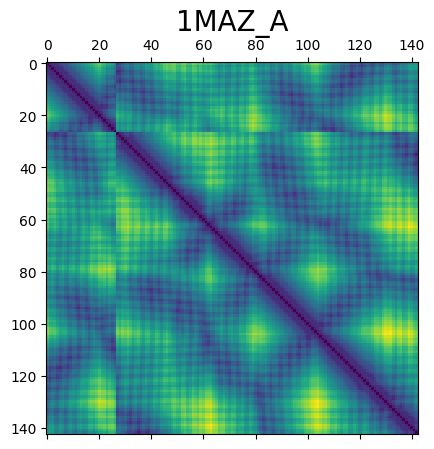

Size of contact map for protein 1MAZ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:143 VS Length of sequence:221
35.3% of the sequence is missing.


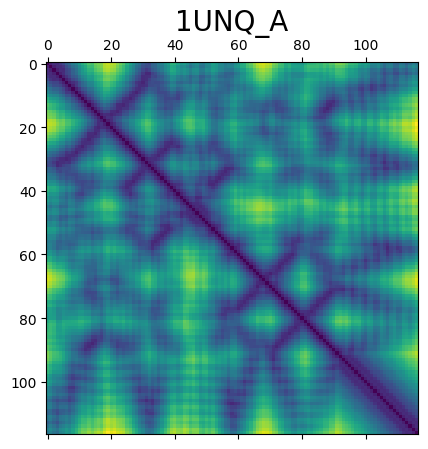

Size of contact map for protein 1UNQ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:117 VS Length of sequence:125
6.4% of the sequence is missing.


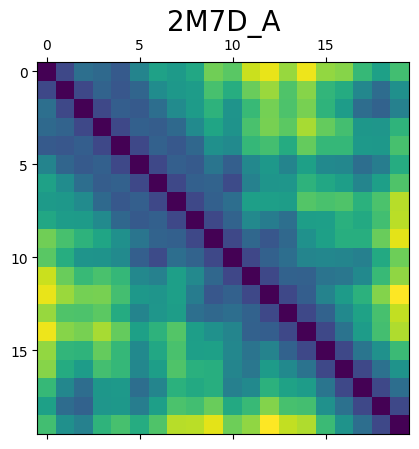

Size of contact map for protein 2M7D aligns with the length of protein sequence
Size of contact map:20, Length of sequence:20


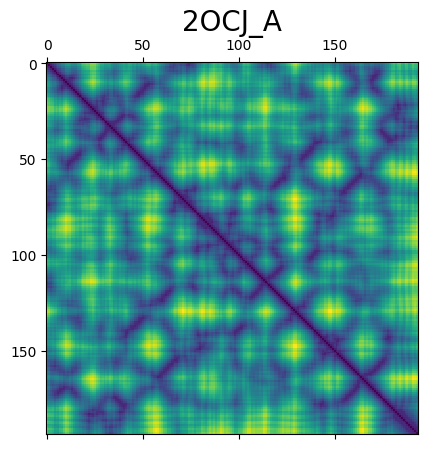

Size of contact map for protein 2OCJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:194 VS Length of sequence:219
11.4% of the sequence is missing.


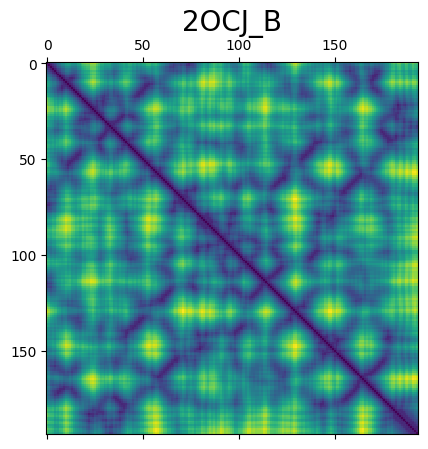

Size of contact map for protein 2OCJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:194 VS Length of sequence:219
11.4% of the sequence is missing.


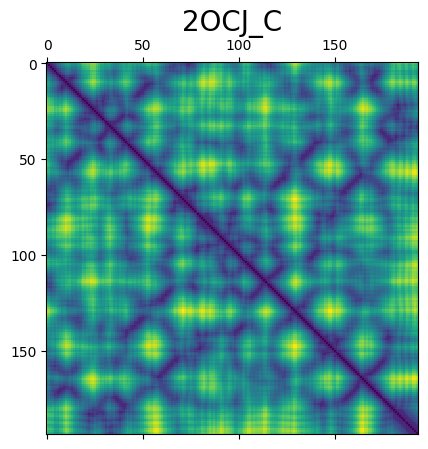

Size of contact map for protein 2OCJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:194 VS Length of sequence:219
11.4% of the sequence is missing.


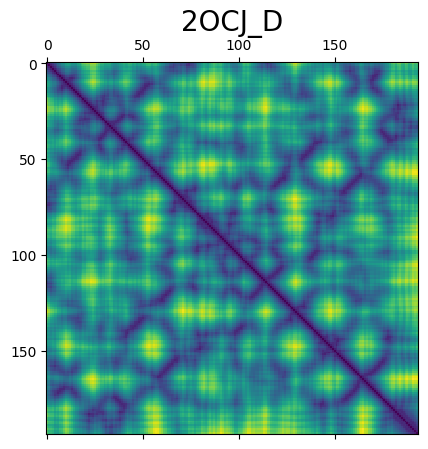

Size of contact map for protein 2OCJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:194 VS Length of sequence:219
11.4% of the sequence is missing.


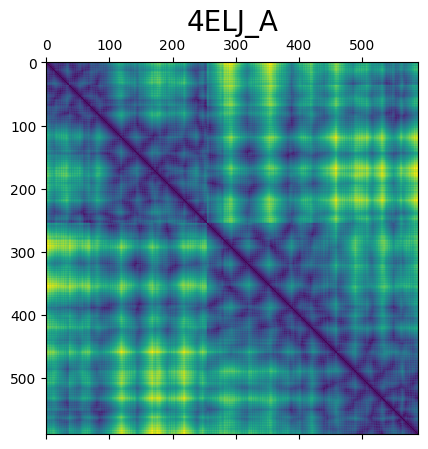

Size of contact map for protein 4ELJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:590 VS Length of sequence:656
10.1% of the sequence is missing.


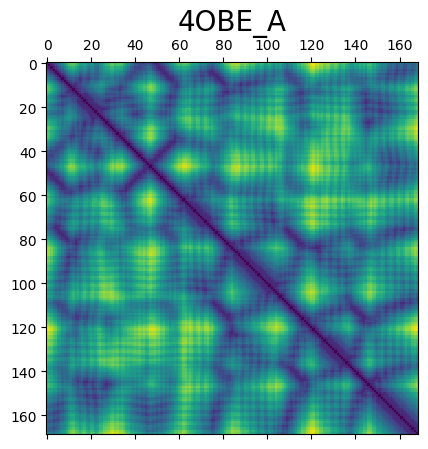

Size of contact map for protein 4OBE is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:169 VS Length of sequence:170
0.6% of the sequence is missing.


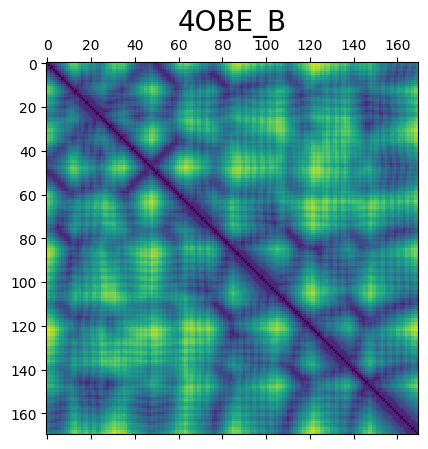

Size of contact map for protein 4OBE aligns with the length of protein sequence
Size of contact map:170, Length of sequence:170


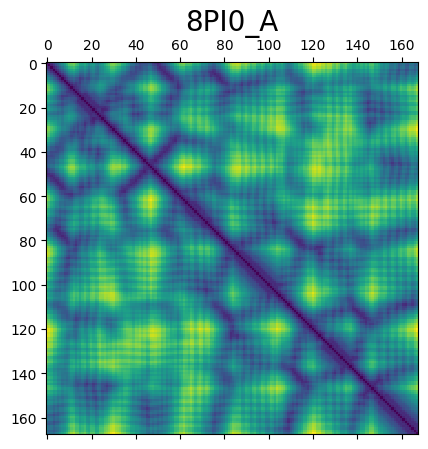

Size of contact map for protein 8PI0 aligns with the length of protein sequence
Size of contact map:168, Length of sequence:168


In [35]:
#Option 2: parse using residues
models = process_pdb_files("protein_structures")
# generate contact maps from structure data
contact_maps = get_contact_maps_per_chain(models)
# visualise and analyse
sequence_lengths,ca_atoms_lengths = set_up(contact_maps)
analyse_and_display_all_contact_maps(contact_maps,sequence_lengths,ca_atoms_lengths)

C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6715.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6716.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6717.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6718.
  warnings.warn(
C:\Users\aguba\AppData\Local\Programs\Python\Python311\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6719.
  warnings.warn(
C:\Users\aguba\AppData\Lo

{'1MAZ': 221, '1UNQ': 125, '2M7D': 20, '2OCJ': 219, '4ELJ': 656, '4OBE': 170, '8PI0': 168}
{'1MAZ_A': 143, '1UNQ_A': 117, '2M7D_A': 20, '2OCJ_A': 194, '2OCJ_B': 194, '2OCJ_C': 194, '2OCJ_D': 194, '4ELJ_A': 590, '4OBE_A': 169, '4OBE_B': 170, '8PI0_A': 168}


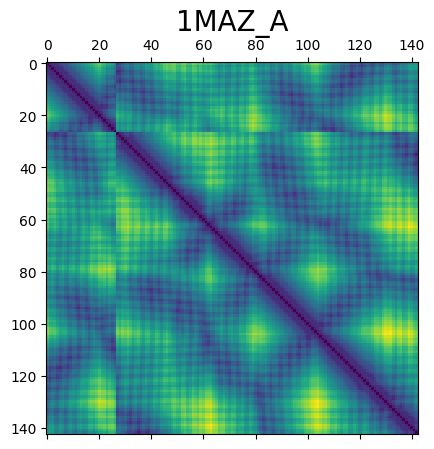

Size of contact map for protein 1MAZ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:143 VS Length of sequence:221
35.3% of the sequence is missing.


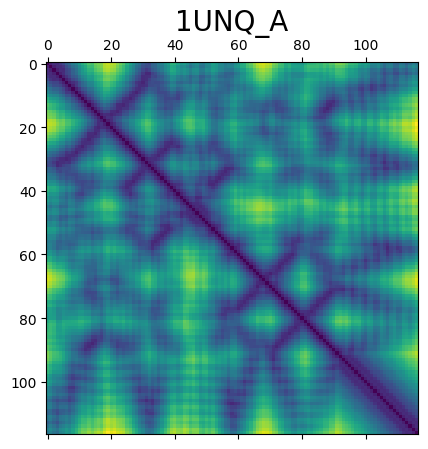

Size of contact map for protein 1UNQ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:117 VS Length of sequence:125
6.4% of the sequence is missing.


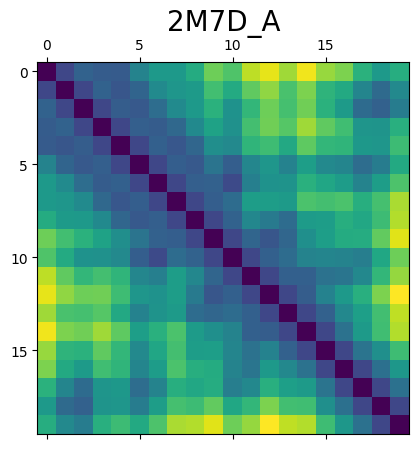

Size of contact map for protein 2M7D aligns with the length of protein sequence
Size of contact map:20, Length of sequence:20


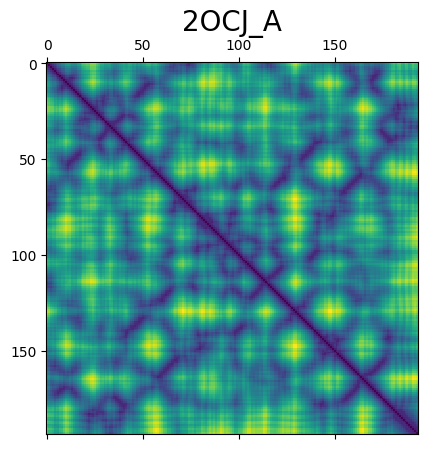

Size of contact map for protein 2OCJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:194 VS Length of sequence:219
11.4% of the sequence is missing.


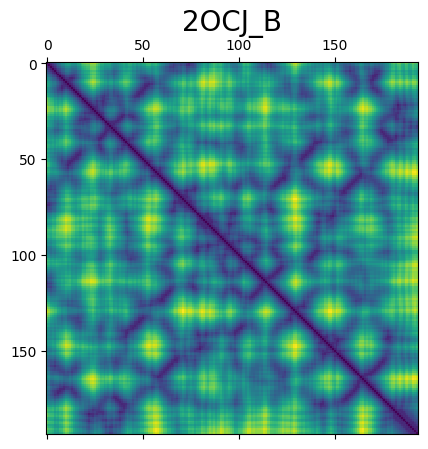

Size of contact map for protein 2OCJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:194 VS Length of sequence:219
11.4% of the sequence is missing.


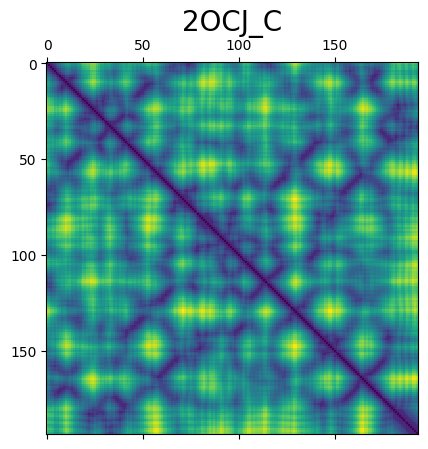

Size of contact map for protein 2OCJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:194 VS Length of sequence:219
11.4% of the sequence is missing.


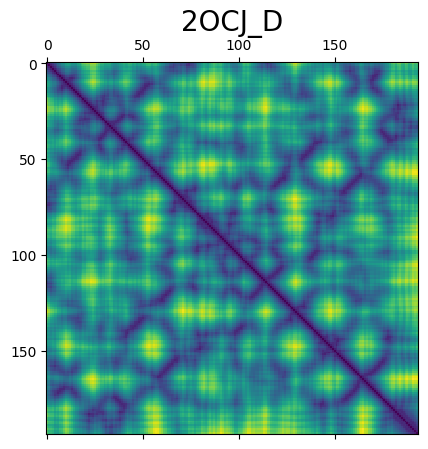

Size of contact map for protein 2OCJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:194 VS Length of sequence:219
11.4% of the sequence is missing.


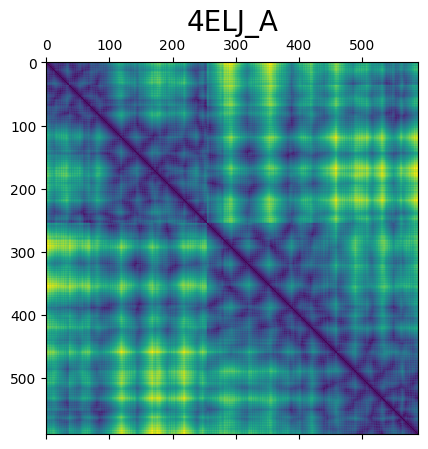

Size of contact map for protein 4ELJ is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:590 VS Length of sequence:656
10.1% of the sequence is missing.


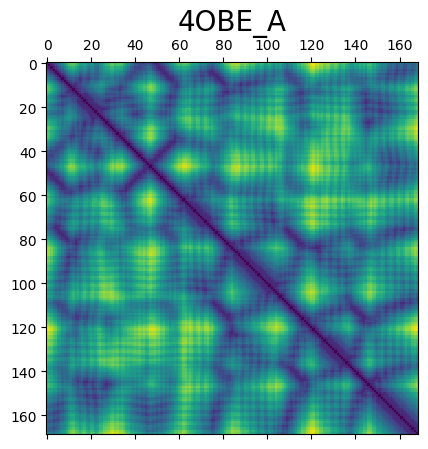

Size of contact map for protein 4OBE is shorter than the length of the original protein sequence. Some residues are missing in this contact map.
Size of contact map:169 VS Length of sequence:170
0.6% of the sequence is missing.


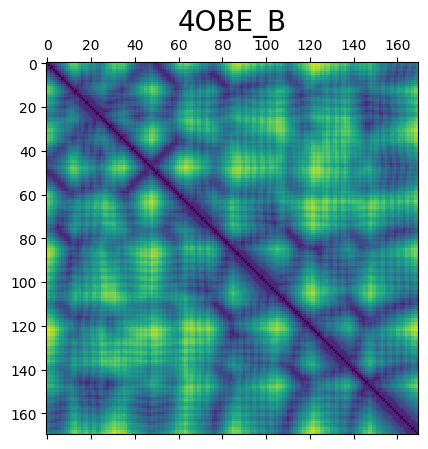

Size of contact map for protein 4OBE aligns with the length of protein sequence
Size of contact map:170, Length of sequence:170


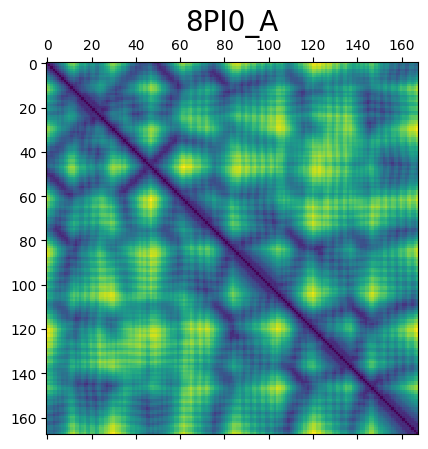

Size of contact map for protein 8PI0 aligns with the length of protein sequence
Size of contact map:168, Length of sequence:168


In [36]:
#Option 3: parse using chains
proteins = process_pdb_files_by_chains("protein_structures")
# generate contact maps from structure data
contact_maps =  get_contact_maps_per_chain(proteins)
# visualise and analyse
sequence_lengths,ca_atoms_lengths = set_up(contact_maps)
analyse_and_display_all_contact_maps(contact_maps,sequence_lengths,ca_atoms_lengths)